In [8]:
import numpy as np
from scipy.ndimage import convolve, gaussian_filter
from skimage.morphology import remove_small_objects
from PIL import Image
import matplotlib.pyplot as plt

In [14]:
def load_image(image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    return np.asarray(image)

def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
    return (image * 255).astype(np.uint8)

def preprocess_image(image, sigma=1):
    return gaussian_filter(image, sigma=sigma)  # Applying Gaussian filter for noise reduction

def sobel_operator(image):
    # Sobel kernels
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

    Ky = np.array([[-1, -2, -1],
                   [ 0,  0,  0],
                   [ 1,  2,  1]])

    # Compute gradients
    Gx = convolve(image, Kx)
    Gy = convolve(image, Ky)

    # Gradient magnitude
    G = np.sqrt(Gx**2 + Gy**2)
    return normalize(G)

def sobel_operator_with_threshold(image, threshold=100):
    G = sobel_operator(image)
    G[G < threshold] = 0  # Suppressing weak edges
    return G

def remove_noise(edges, min_size=100):
    # Convert edges to binary
    binary_edges = edges > 0
    # Remove small objects (noise) based on min_size
    cleaned_edges = remove_small_objects(binary_edges, min_size=min_size)
    return (cleaned_edges * 255).astype(np.uint8)

def morphological_cleanup(edges, disk_size=2):
    binary_edges = (edges > 0).astype(bool)  # Explicitly converting edges to boolean
    # Performing closing followed by opening to remove noise
    closed_edges = binary_closing(binary_edges, footprint=disk(disk_size))
    cleaned_edges = binary_opening(closed_edges, footprint=disk(disk_size))
    return (cleaned_edges * 255).astype(np.uint8)


def edge_detection_pipeline(image_path, sigma=1, threshold=100, min_size=50, disk_size=2):
    # Loading and preprocessing image
    image = load_image(image_path)
    smoothed_image = preprocess_image(image, sigma)
    edges = sobel_operator_with_threshold(smoothed_image, threshold)
    # Removing noise
    cleaned_edges = remove_noise(edges, min_size)
    # Applying morphological operations
    final_edges = morphological_cleanup(cleaned_edges, disk_size)
    return image, final_edges



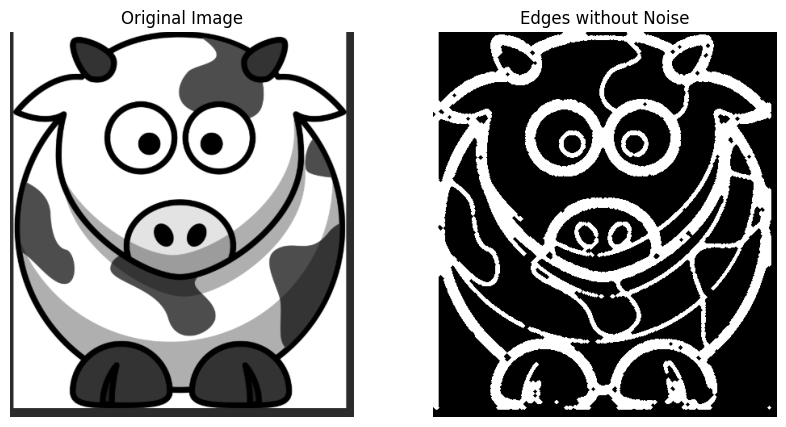

In [31]:
if __name__ == "__main__":
    image_path = "/content/Screenshot 2024-12-19 191305.png"  # Replace with your image path
    sigma = 0.6  # Adjust for noise reduction
    threshold = 100  # Adjust for edge strength
    min_size = 100  # Minimum size for noise removal
    disk_size = 2  # Size of the structuring element for morphological operations

    original_image, edges = edge_detection_pipeline(image_path, sigma, threshold, min_size, disk_size)

    # Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Edges without Noise")
    plt.imshow(edges, cmap="gray")
    plt.axis("off")

    plt.show()